In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats

# Importing data

In [2]:
df = pd.read_excel("Weather_PGH.xlsx")
df.head() # to see what the dataset looks like

,Date,Weather,High,Low,Precipitation (in),Wunderground?
0,2019-05-10,Cloudy,58,40,0.0,No
1,2019-05-11,Partly Cloudy,55,35,0.0,No
2,2019-05-12,Mostly Sunny,59,35,0.0,No
3,2019-05-13,Mostly Sunny,63,42,0.0,No
4,2019-05-14,Mostly Cloudy,64,43,0.0,No


In [3]:
df.shape # 731 days of data were used

(731, 6)

In [4]:
# Not all the data could be obtained from Wunderground due to a bug in their system
# The ones that are labeled as "No" were obtained from the Weather Channel
df.groupby("Wunderground?").count() 

,Date,Weather,High,Low,Precipitation (in)
Wunderground?,,,,,
No,39,39,39,39,39
Yes,692,692,692,692,692


# Converting Weather to an Integer Value

To index into the matrix, I converted the weather states for each day into a non-negative integer value

In [5]:
def weather_number(weather_name): 
    num = -1
    if weather_name == "Mostly Sunny": 
        num = 0
    elif weather_name == "Partly Cloudy":
        num = 1
    elif weather_name == "Mostly Cloudy":
        num = 2
    elif weather_name == "Cloudy": 
        num = 3
    elif weather_name == "Foggy":
        num = 4
    elif weather_name == "Scattered Showers":
        num = 5
    elif weather_name == "Thunderstorm": 
        num = 6
    elif weather_name == "Snow":
        num = 7
    return num

In [6]:
df["weather_num"] = df["Weather"].apply(weather_number)
df.head()

,Date,Weather,High,Low,Precipitation (in),Wunderground?,weather_num
0,2019-05-10,Cloudy,58,40,0.0,No,3
1,2019-05-11,Partly Cloudy,55,35,0.0,No,1
2,2019-05-12,Mostly Sunny,59,35,0.0,No,0
3,2019-05-13,Mostly Sunny,63,42,0.0,No,0
4,2019-05-14,Mostly Cloudy,64,43,0.0,No,2


# Creating 1-Step Transition Matrix P

In [7]:
# General function to create a transition matrix P, assuming first-order condition is met
# Input: a series, also known as a stochastic process {X(t)}
# Outputs: count matrix (used to prove first-order condition is met), transition_matrix (P)
def create_transition_matrix(series): 
    
    # Initialize to make 
    unique_vals = len(np.unique(series)) 
    counts = np.zeros((unique_vals, unique_vals))
    n = len(series)
    
    # increment count when transition occures
    for i in range(n-1):
        current = series[i]
        future = series[i+1]
        counts[current][future] += 1
    
    # Convert counts to probabilities
    transition_matrix = counts/counts.sum(axis=1)[:,None]
    return counts, transition_matrix

In [8]:
count_mat, mat = create_transition_matrix(df["weather_num"])
np.around(mat, decimals=4) 
# For the final presentation and report, I rounded to the nearest 4 decimal-places for formatting purposes.

array([[0.3204, 0.1553, 0.1748, 0.3301, 0.    , 0.    , 0.0097, 0.0097],
       [0.1831, 0.1408, 0.2113, 0.3521, 0.0141, 0.0986, 0.    , 0.    ],
       [0.1513, 0.1513, 0.2773, 0.3277, 0.    , 0.0504, 0.0252, 0.0168],
       [0.0714, 0.0652, 0.1273, 0.5373, 0.0155, 0.1056, 0.    , 0.0776],
       [0.25  , 0.    , 0.25  , 0.375 , 0.125 , 0.    , 0.    , 0.    ],
       [0.1481, 0.0741, 0.0926, 0.4444, 0.0185, 0.1481, 0.    , 0.0741],
       [0.5   , 0.    , 0.25  , 0.25  , 0.    , 0.    , 0.    , 0.    ],
       [0.0816, 0.0408, 0.0816, 0.449 , 0.    , 0.    , 0.    , 0.3469]])

# Showing why Markov Chains work

## Independence Model does not Hold

For the independence model, one would assume that $\{X_0, X_1, ...\}$ are all independent.
The best estimates for the probability that the chain is in state J is the total number of occurrences where the matrix is in state j divided by the total number of events, or $\hat{P}_i = \frac{\text{number i's}}{731}$

In [9]:
weather_counts = df.groupby("weather_num").count()["Date"]
weather_prop = weather_counts / 731 # calculates approximation of P_i

One would use the formula $N \times \hat{P}_i \times \hat{P}_j$ to calculate the expected number of occurences there will be "ij" in the chain, assuming the independence model works.

In [10]:
expected = np.zeros((8, 8))
for i in range(8):
    for j in range(8): 
        expected[i][j] = weather_prop[i]*weather_prop[j]*731 # N = 731 in our example

Use a probability plot to assess the fit of the indepdence model. We see that the ordered values don't fit the model too well, with some bigger deviation in the tails of the normal probability plot

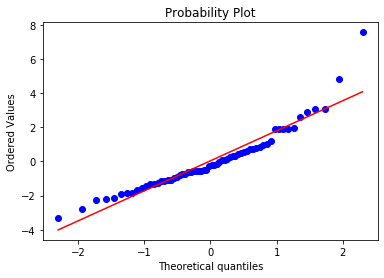

In [11]:
normalized = []
for i in range(8):
    for j in range(8): 
        if expected[i][j] == 0: continue # skip, since we don't want 0 in the denominator
        normalized.append((count_mat[i][j] - expected[i][j]) / math.sqrt(expected[i][j])) # normalize
scipy.stats.probplot(normalized, plot = plt) # normal probability plot
plt.show()

## 1st-Order Markov Chain

In [12]:
def create_second_order(series): 
    counts = np.zeros((64, 8))
    n = len(series)
    for i in range(n-2):
        current = series[i]
        next_val = series[i+1]
        future_val = series[i+2]
        counts[8*current + next_val][future_val] += 1
    return counts
second_order = create_second_order(df["weather_num"])

In [13]:
sec_order_sum = np.sum(second_order, axis = 1)
expected_sec_order = np.zeros((64, 8))

for i in range(64):
    for j in range(8):
        expected_sec_order[i][j] = mat[i % 8][j] * sec_order_sum[i]

In [14]:
# normalize the deviation of the expected from the actual
normalized = []
for i in range(64):
    for j in range(8):
        if expected_sec_order[i][j] == 0: continue  # skip, since we don't want 0 in the denominator
        normalized.append((second_order[i][j] - expected_sec_order[i][j]) / math.sqrt(expected_sec_order[i][j]))

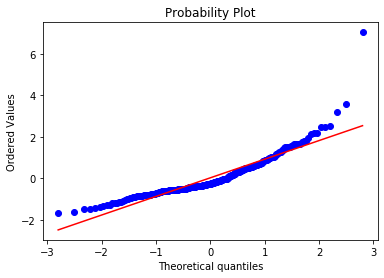

In [15]:
scipy.stats.probplot(normalized, plot = plt)
plt.show()

Looking at the normal probability plot, we see that there is an improvement than when an independence model was assumed. We thus choose to use the first-order condition. 

# Creating Multi-Step Transition Matrix

$P^{(n)} = P^n$, by Chapman-Kolmogorov Equations

In [16]:
np.around(np.linalg.matrix_power(mat, 2), 4)

array([[0.1868, 0.12  , 0.1825, 0.4019, 0.0073, 0.059 , 0.0075, 0.035 ],
       [0.1597, 0.1105, 0.1778, 0.4176, 0.011 , 0.0763, 0.0071, 0.04  ],
       [0.163 , 0.1125, 0.1894, 0.4064, 0.0082, 0.071 , 0.0085, 0.0411],
       [0.1183, 0.0856, 0.15  , 0.4645, 0.0132, 0.0852, 0.0039, 0.0793],
       [0.1759, 0.1011, 0.192 , 0.4128, 0.0214, 0.0522, 0.0087, 0.0357],
       [0.1394, 0.0904, 0.1482, 0.4502, 0.013 , 0.0808, 0.0038, 0.0742],
       [0.2159, 0.1318, 0.1885, 0.3813, 0.0039, 0.039 , 0.0112, 0.0285],
       [0.1064, 0.0742, 0.131 , 0.4651, 0.0075, 0.0555, 0.0029, 0.1574]])

In [17]:
np.around(np.linalg.matrix_power(mat, 7), 4)

array([[0.1415, 0.0974, 0.1632, 0.4393, 0.011 , 0.0754, 0.0055, 0.0667],
       [0.1414, 0.0974, 0.1631, 0.4394, 0.011 , 0.0754, 0.0055, 0.0669],
       [0.1414, 0.0974, 0.1631, 0.4394, 0.011 , 0.0754, 0.0055, 0.0668],
       [0.1411, 0.0972, 0.1629, 0.4397, 0.011 , 0.0754, 0.0055, 0.0673],
       [0.1415, 0.0974, 0.1632, 0.4393, 0.011 , 0.0754, 0.0055, 0.0668],
       [0.1412, 0.0972, 0.1629, 0.4396, 0.011 , 0.0754, 0.0055, 0.0672],
       [0.1416, 0.0975, 0.1632, 0.4392, 0.0109, 0.0754, 0.0055, 0.0666],
       [0.1408, 0.097 , 0.1627, 0.4399, 0.011 , 0.0754, 0.0055, 0.0677]])

# Limiting Distribution

An approximation to $P^\infty$ is $P^{1000}$. We can see that there are identical rows, so that is the limiting distribution

In [18]:
P_thousand = np.linalg.matrix_power(mat, 1000)

In [19]:
pi = P_thousand[0]
np.around(pi, 5)

array([0.14124, 0.09728, 0.16297, 0.43957, 0.01096, 0.07539, 0.00548,
       0.0671 ])